In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("final_data.csv")
y = df['PCOS (Y/N)']
X = df.drop(columns=['PCOS (Y/N)'])  

print(X.head())

   Age (yrs)   BMI  Pulse rate(bpm)  Menstrual Cycle Length(days)  \
0         28  19.3               78                             5   
1         36  24.9               74                             5   
2         33  25.3               72                             5   
3         37  29.7               72                             5   
4         25  20.1               72                             5   

   Marriage Status (Yrs)  Pregnant(Y/N)  No. of abortions  \
0                    7.0              0                 0   
1                   11.0              1                 0   
2                   10.0              1                 0   
3                    4.0              0                 0   
4                    1.0              1                 0   

   I   beta-HCG(mIU/mL)  II    beta-HCG(mIU/mL)  FSH/LH  ...  RBS(mg/dl)_low  \
0                  1.99                    1.99    2.16  ...             0.0   
1                 60.80                    1.99    6.17  .

In [4]:
# selecting only numerical columns for clustering
numerical_cols = X.select_dtypes(include=['number']).columns
X = df[numerical_cols]

# normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced shape: {X_pca.shape}")

Reduced shape: (529, 40)


## K-Means Clustering

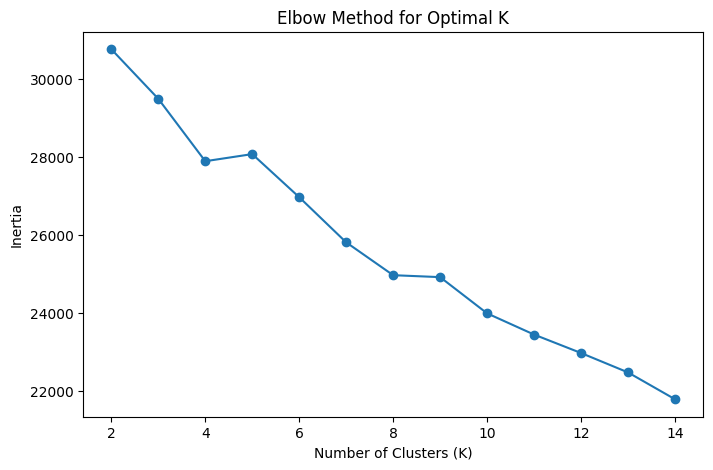

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 15)  # Try K values from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


No clear "elbow point" suggesting optimal K is not obvious. Instead, inertia decreases gradually without a sharp bend. 
- Try K=4, 8 based on elbow graph and try Silhouette Score to determine K
- Explore Agglomerative Clustering
- Explore DBSCAN for density-based clustering (works will if data have a lot of noise or continuous variation)

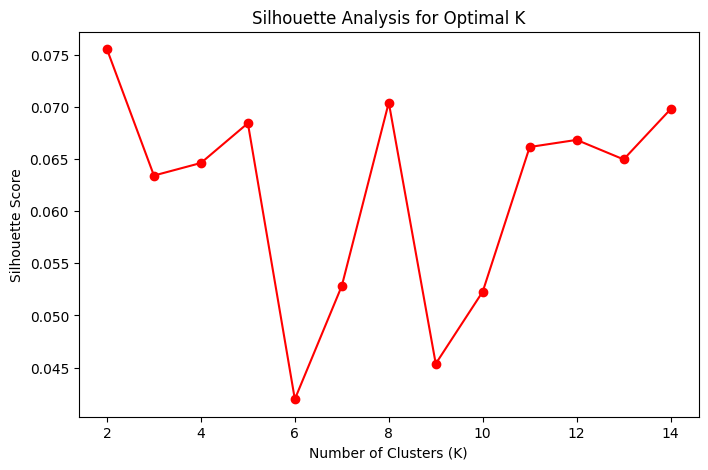

In [7]:
# check silhouette score for each K, check which K gives the best separation

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# plot Silhouette Score
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(2, 15), silhouette_scores, marker='o', color='red')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.show()


Choose K with highest silhouette score (ideally > 0.5), hence explore K= 2,5,8,14

### K-Means Clustering (K=2)

In [8]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

print("Cluster Labels:", cluster_labels[:10])  # check first 10 labels

Cluster Labels: [0 0 1 0 0 0 0 0 0 0]


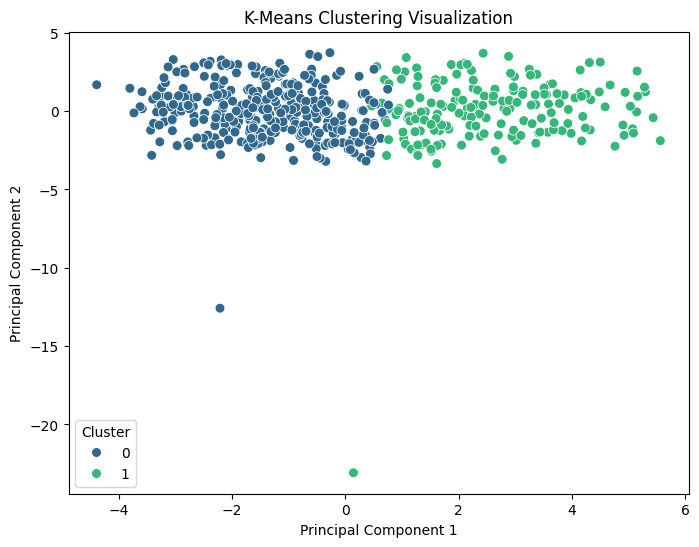

In [9]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()


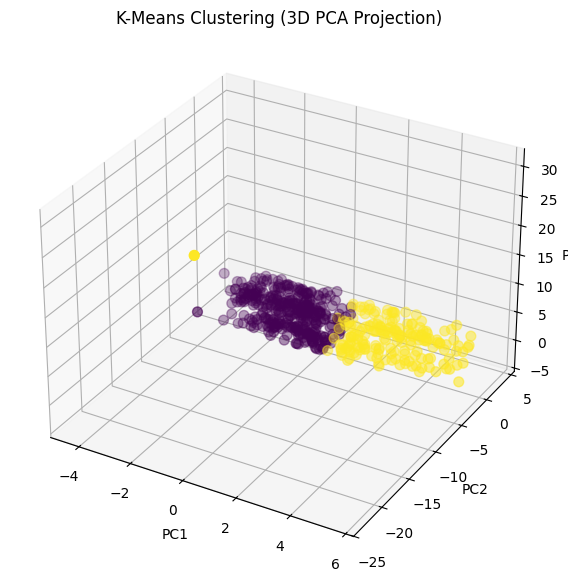

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("K-Means Clustering (3D PCA Projection)")
plt.show()


In [11]:
import pandas as pd

df["Cluster"] = cluster_labels  # add cluster labels to the original DataFrame
print(df["Cluster"].value_counts())  # check how many data points per cluster


Cluster
0    345
1    184
Name: count, dtype: int64


In [12]:
df.groupby("Cluster").mean()


,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.092754,31.849275,23.364928,73.208696,5.144928,7.737681,0.385507,0.281159,512.661933,224.638116,...,0.002899,0.988406,0.002899,0.997101,0.000000,1.000000,0.243478,0.756522,0.156522,0.843478
1,0.755435,30.630435,26.120652,73.972826,4.548913,7.490217,0.391304,0.288043,985.356082,276.240973,...,0.000000,0.967391,0.005435,0.994565,0.005435,0.994565,0.222826,0.777174,0.163043,0.836957


In [13]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# load true labels (assuming 1 = PCOS positive, 0 = negative)
true_labels = df['PCOS (Y/N)']

# compute ARI and NMI
ari_score = adjusted_rand_score(true_labels, df['Cluster'])  # 1=perfect match, 0=random clusters
nmi_score = normalized_mutual_info_score(true_labels, df['Cluster'])  # higher better

print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Adjusted Rand Index (ARI): 0.4959
Normalized Mutual Information (NMI): 0.3675


### K-Means Clustering (K=4)

In [38]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

print("Cluster Labels:", cluster_labels[:10])  # check first 10 labels

Cluster Labels: [1 0 0 1 0 0 1 0 1 1]


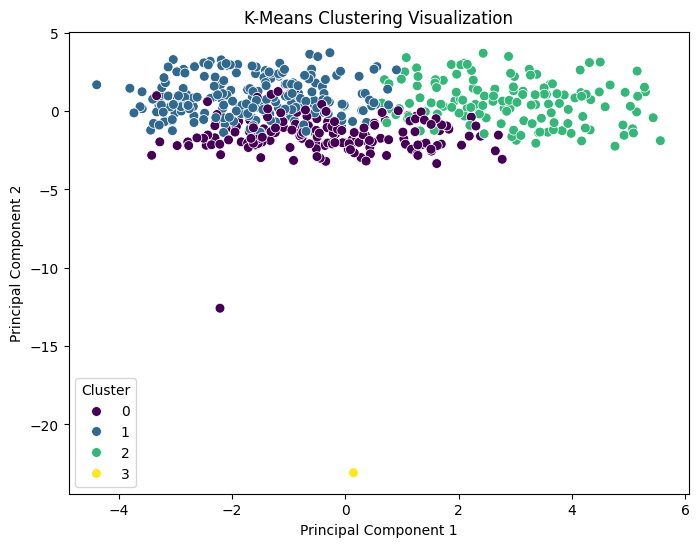

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()

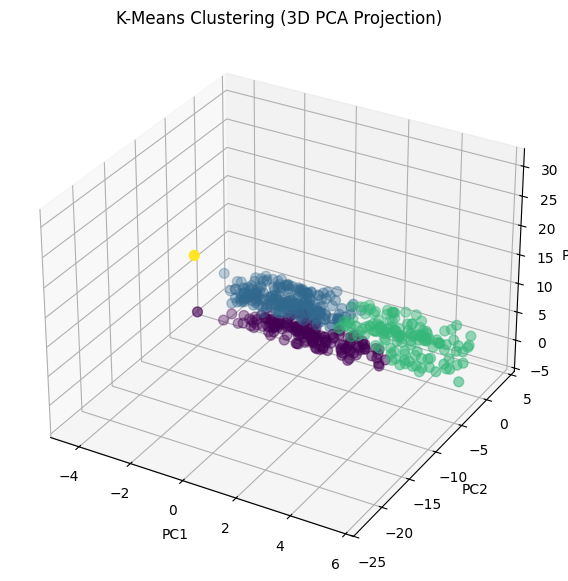

In [41]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("K-Means Clustering (3D PCA Projection)")
plt.show()


In [42]:
df["Cluster"] = cluster_labels  # add cluster labels to the original DataFrame
print(df["Cluster"].value_counts())  # check how many data points per cluster


Cluster
1    216
0    172
2    140
3      1
Name: count, dtype: int64


In [43]:
df.groupby("Cluster").mean()


,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.191860,31.186047,23.388953,73.540698,5.220930,7.662791,1.000000,0.284884,1331.913070,488.752913,...,0.00000,0.988372,0.005814,0.994186,0.0,1.0,0.069767,0.930233,0.232558,0.767442
1,0.101852,32.351852,23.587037,73.129630,5.087963,8.037037,0.009259,0.296296,240.051481,16.633241,...,0.00463,0.986111,0.000000,1.000000,0.0,1.0,0.342593,0.657407,0.106481,0.893519
2,0.828571,30.242857,26.566429,73.935714,4.357143,7.083571,0.221429,0.264286,551.655200,290.487271,...,0.00000,0.964286,0.000000,1.000000,0.0,1.0,0.278571,0.721429,0.150000,0.850000
3,0.000000,38.000000,30.100000,72.000000,5.000000,2.000000,0.000000,0.000000,1.990000,1.990000,...,0.00000,1.000000,1.000000,0.000000,1.0,0.0,0.000000,1.000000,0.000000,1.000000


In [44]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# load true labels (assuming 1 = PCOS positive, 0 = negative)
true_labels = df['PCOS (Y/N)']

# compute ARI and NMI
ari_score = adjusted_rand_score(true_labels, df['Cluster'])  # 1=perfect match, 0=random clusters
nmi_score = normalized_mutual_info_score(true_labels, df['Cluster'])  # higher better

print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Adjusted Rand Index (ARI): 0.2550
Normalized Mutual Information (NMI): 0.2491


### K-Means Clustering (K=5)

In [45]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

print("Cluster Labels:", cluster_labels[:10])  # check first 10 labels

Cluster Labels: [4 3 3 4 3 3 4 3 4 4]


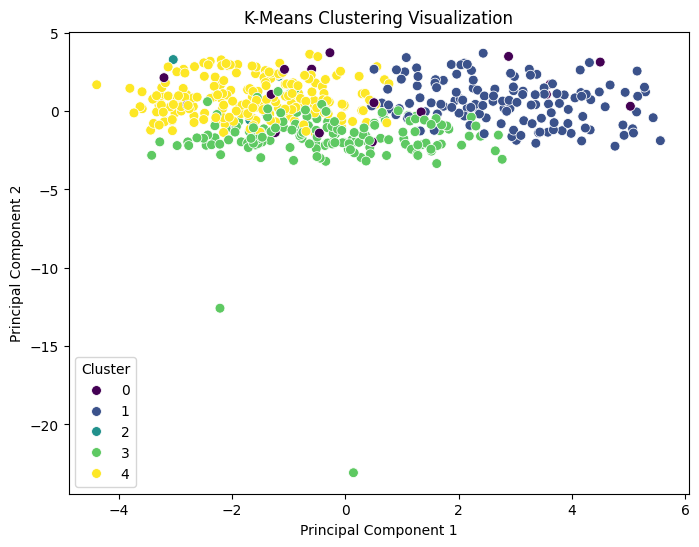

In [46]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()


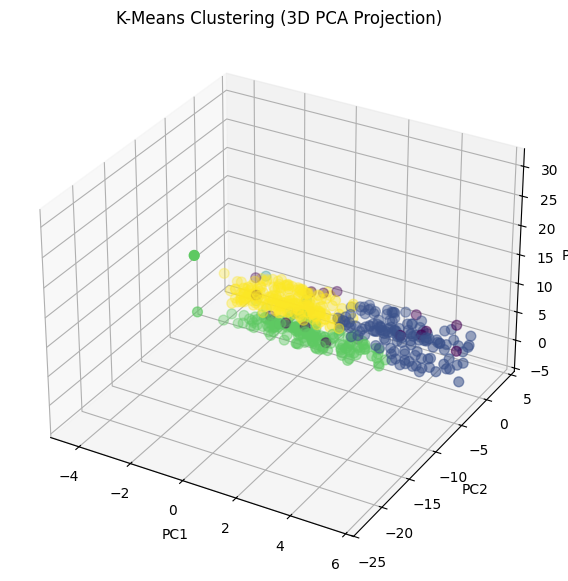

In [47]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("K-Means Clustering (3D PCA Projection)")
plt.show()


In [48]:
df["Cluster"] = cluster_labels  # add cluster labels to the original DataFrame
print(df["Cluster"].value_counts())  # check how many data points per cluster


Cluster
4    206
3    165
1    137
0     18
2      3
Name: count, dtype: int64


In [49]:
df.groupby("Cluster").mean()


,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.444444,29.333333,27.183333,73.277778,5.055556,6.194444,0.388889,0.277778,159.603889,36.182778,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.500000,0.277778,0.722222
1,0.817518,30.423358,26.243066,73.927007,4.379562,7.198540,0.218978,0.270073,558.066774,290.749401,...,0.000000,0.963504,0.000000,1.000000,0.000000,1.000000,0.248175,0.751825,0.131387,0.868613
2,0.000000,29.666667,25.166667,71.333333,6.000000,6.666667,0.333333,0.000000,285.496667,167.100000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.666667,0.000000,1.000000
3,0.200000,31.345455,23.339394,73.521212,5.230303,7.772727,0.993939,0.284848,1377.833988,504.690309,...,0.000000,0.987879,0.012121,0.987879,0.006061,0.993939,0.060606,0.939394,0.212121,0.787879
4,0.087379,32.364078,23.572816,73.184466,5.048544,7.997573,0.014563,0.296117,245.858107,19.754029,...,0.004854,0.985437,0.000000,1.000000,0.000000,1.000000,0.344660,0.655340,0.126214,0.873786


In [50]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# load true labels (assuming 1 = PCOS positive, 0 = negative)
true_labels = df['PCOS (Y/N)']

# compute ARI and NMI
ari_score = adjusted_rand_score(true_labels, df['Cluster'])  # 1=perfect match, 0=random clusters
nmi_score = normalized_mutual_info_score(true_labels, df['Cluster'])  # higher better

print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Adjusted Rand Index (ARI): 0.2389
Normalized Mutual Information (NMI): 0.2280


### K-Means Clustering (K=8)

In [20]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

print("Cluster Labels:", cluster_labels[:10])  # check first 10 labels

Cluster Labels: [0 7 6 2 6 0 2 6 2 2]


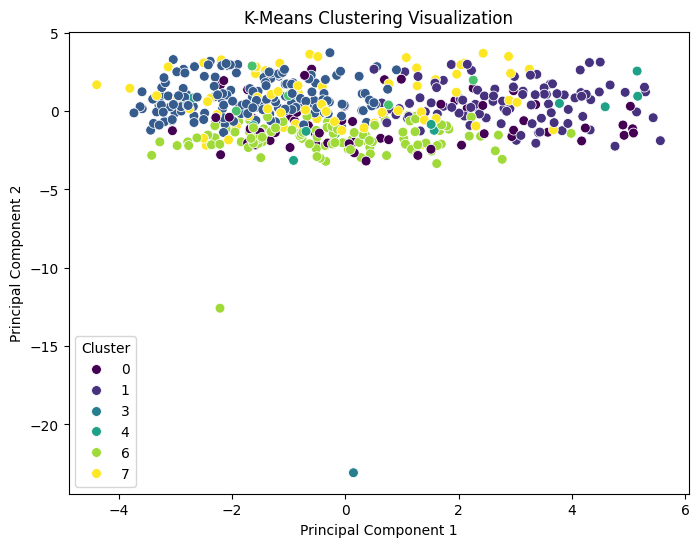

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()


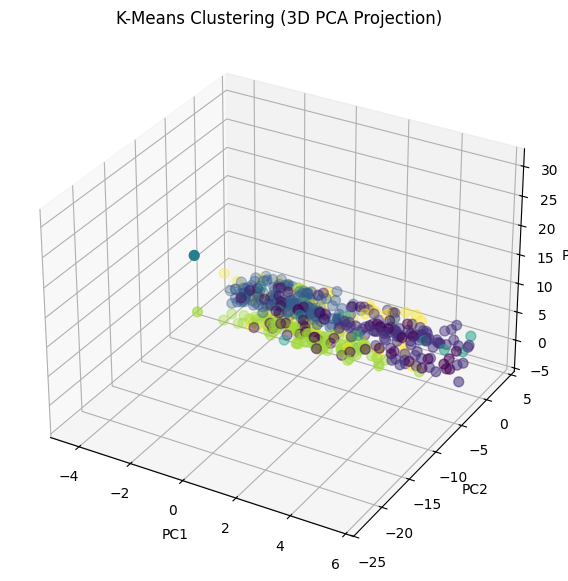

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("K-Means Clustering (3D PCA Projection)")
plt.show()


In [23]:
df["Cluster"] = cluster_labels  # add cluster labels to the original DataFrame
print(df["Cluster"].value_counts())  # check how many data points per cluster


Cluster
2    165
6    116
1     98
7     69
0     63
4     10
5      7
3      1
Name: count, dtype: int64


In [ ]:
df.groupby("Cluster").mean()

,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.349206,32.031746,24.946032,76.317460,5.047619,8.780952,0.476190,0.238095,366.329683,250.683016,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.253968,0.746032,0.174603,0.825397
1,0.795918,29.938776,26.394898,73.387755,4.336735,6.760204,0.173469,0.275510,110.722531,54.955388,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.193878,0.806122,0.010204,0.989796
2,0.115152,32.090909,23.466061,72.830303,5.018182,7.563636,0.012121,0.254545,261.630061,2.098303,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.309091,0.690909,0.000000,1.000000
3,0.000000,38.000000,30.100000,72.000000,5.000000,2.000000,0.000000,0.000000,1.990000,1.990000,...,0.0,1.0,1.000000,0.000000,1.0,0.0,0.000000,1.000000,0.000000,1.000000
4,0.500000,33.100000,26.530000,73.100000,4.800000,8.100000,0.200000,0.700000,49.395000,6.150000,...,0.1,0.0,0.000000,1.000000,0.0,1.0,0.200000,0.800000,0.100000,0.900000
5,0.285714,26.714286,24.400000,72.857143,4.428571,4.785714,0.142857,0.142857,3173.887143,2328.195714,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.285714,0.714286,0.285714,0.714286
6,0.189655,30.810345,23.591379,73.206897,5.396552,7.758621,1.000000,0.293103,1795.303517,726.852681,...,0.0,1.0,0.008621,0.991379,0.0,1.0,0.017241,0.982759,0.000000,1.000000
7,0.333333,32.565217,23.682609,73.130435,4.797101,8.224638,0.536232,0.347826,726.188261,88.809275,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.478261,0.521739,1.000000,0.000000


In [25]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# load true labels (assuming 1 = PCOS positive, 0 = negative)
true_labels = df['PCOS (Y/N)']

# compute ARI and NMI
ari_score = adjusted_rand_score(true_labels, df['Cluster'])  # 1=perfect match, 0=random clusters
nmi_score = normalized_mutual_info_score(true_labels, df['Cluster'])  # higher better

print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Adjusted Rand Index (ARI): 0.1191
Normalized Mutual Information (NMI): 0.1187


### K-Means Clustering (K=14)

In [26]:
optimal_k = 14
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

print("Cluster Labels:", cluster_labels[:10])  # check first 10 labels

Cluster Labels: [2 4 8 1 8 4 1 8 1 1]


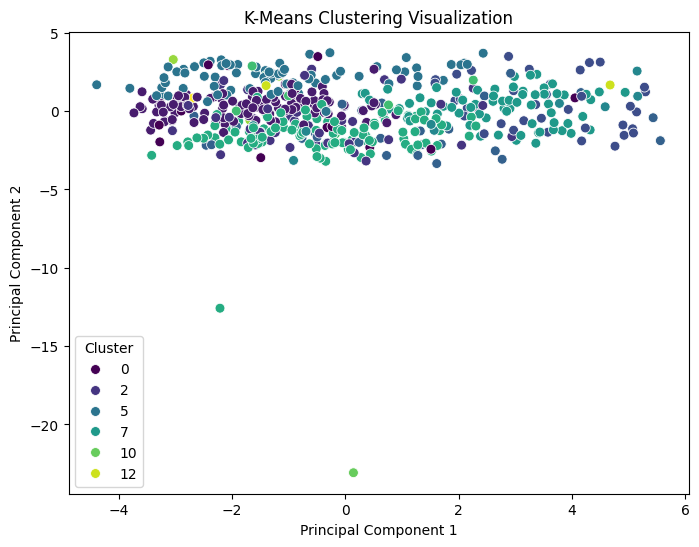

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization")
plt.legend(title="Cluster")
plt.show()


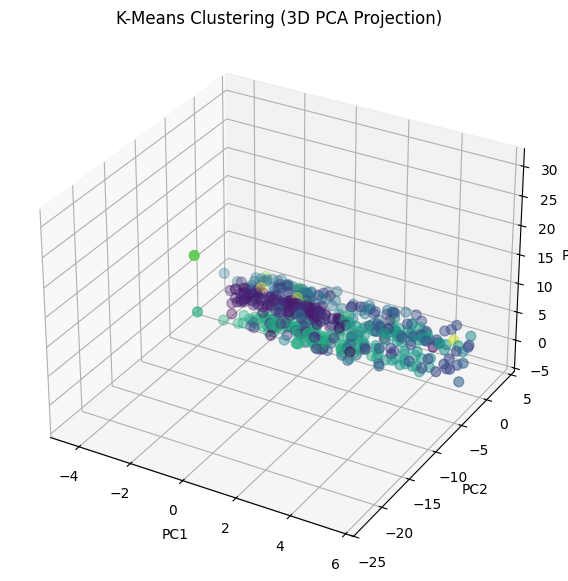

In [28]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("K-Means Clustering (3D PCA Projection)")
plt.show()


In [29]:
df["Cluster"] = cluster_labels  # add cluster labels to the original DataFrame
print(df["Cluster"].value_counts())  # check how many data points per cluster


Cluster
8     114
1     112
5      78
7      74
2      46
3      36
4      30
0      16
6       9
9       7
11      3
12      2
13      1
10      1
Name: count, dtype: int64


In [30]:
df.groupby("Cluster").mean()


,PCOS (Y/N),Age (yrs),BMI,Pulse rate(bpm),Menstrual Cycle Length(days),Marriage Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),...,RBS(mg/dl)_low,RBS(mg/dl)_normal,BP _Systolic (mmHg)_high,BP _Systolic (mmHg)_normal,BP _Diastolic (mmHg)_high,BP _Diastolic (mmHg)_normal,I beta-HCG cat_abnormal,I beta-HCG cat_normal,II beta-HCG cat_abnormal,II beta-HCG cat_normal
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.375000,30.312500,23.456250,73.125000,4.875000,8.125000,0.437500,0.375000,234.438750,134.098125,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.312500,0.687500,0.125000,0.875000
1,0.044643,32.348214,23.482143,72.785714,5.098214,7.700893,0.017857,0.285714,2.352143,9.757857,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.017857,0.982143,0.044643,0.955357
2,0.130435,32.608696,24.310870,76.108696,5.108696,9.021739,0.413043,0.304348,356.004565,211.635217,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.304348,0.695652,0.195652,0.804348
3,0.944444,30.861111,28.911111,74.361111,4.888889,7.588889,0.333333,0.194444,271.800278,219.213056,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.388889,0.611111,0.166667,0.833333
4,0.366667,31.500000,25.356667,74.266667,4.866667,8.350000,0.600000,0.233333,910.753000,817.959000,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.033333,0.966667,0.200000,0.800000
5,0.294872,32.166667,23.256410,72.692308,4.884615,7.839744,0.102564,0.256410,1043.313333,52.346410,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.987179,0.012821,0.320513,0.679487
6,0.555556,33.222222,26.655556,72.555556,4.777778,8.111111,0.222222,0.222222,54.324444,6.612222,...,0.0,0.0,0.000000,1.000000,0.0,1.0,0.111111,0.888889,0.111111,0.888889
7,0.756757,29.864865,25.222973,73.716216,4.054054,6.662162,0.283784,0.337838,906.847270,424.366054,...,0.0,1.0,0.000000,1.000000,0.0,1.0,0.094595,0.905405,0.067568,0.932432
8,0.192982,31.035088,23.329825,73.210526,5.394737,7.557018,1.000000,0.271930,1128.196211,268.176588,...,0.0,1.0,0.008772,0.991228,0.0,1.0,0.000000,1.000000,0.201754,0.798246


In [31]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# load true labels (assuming 1 = PCOS positive, 0 = negative)
true_labels = df['PCOS (Y/N)']

# compute ARI and NMI
ari_score = adjusted_rand_score(true_labels, df['Cluster'])  # 1=perfect match, 0=random clusters
nmi_score = normalized_mutual_info_score(true_labels, df['Cluster'])  # higher better

print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')
print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')

Adjusted Rand Index (ARI): 0.0951
Normalized Mutual Information (NMI): 0.1403


Scores generally decreases as K increases

## DBSCAN

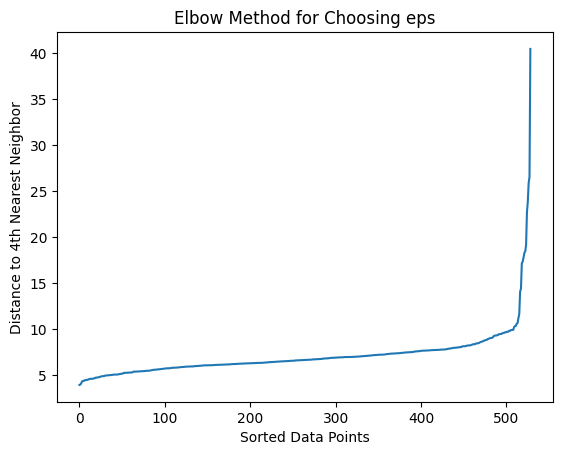

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# sort and plot the k-distances
distances = np.sort(distances[:, 4], axis=0)  # Pick the 4th nearest neighbor
plt.plot(distances)
plt.ylabel("Distance to 4th Nearest Neighbor")
plt.xlabel("Sorted Data Points")
plt.title("Elbow Method for Choosing eps")
plt.show()

In [69]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

true_labels = df['PCOS (Y/N)'] 
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# apply DBSCAN
dbscan = DBSCAN(eps=6, min_samples=4)  # tune these values, increase eps and reduce min_samples for btr scores
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_pca_scaled)

ari_dbscan = adjusted_rand_score(true_labels, df['DBSCAN_Cluster'])
nmi_dbscan = normalized_mutual_info_score(true_labels, df['DBSCAN_Cluster'])

print(f'DBSCAN - Adjusted Rand Index (ARI): {ari_dbscan:.4f}')
print(f'DBSCAN - Normalized Mutual Information (NMI): {nmi_dbscan:.4f}')


DBSCAN - Adjusted Rand Index (ARI): 0.0246
DBSCAN - Normalized Mutual Information (NMI): 0.0032


In [70]:
print(df['DBSCAN_Cluster'].nunique())

4


In [71]:
df['DBSCAN_Cluster'].value_counts()

DBSCAN_Cluster
 0    430
-1     72
 2     15
 1     12
Name: count, dtype: int64

## Gaussian Mixture Model
- probabilistic model assuming data comes from multiple gaussian distributions
- assigns points to clusters using probabilities
- handles overlapping clusters better than K-Means

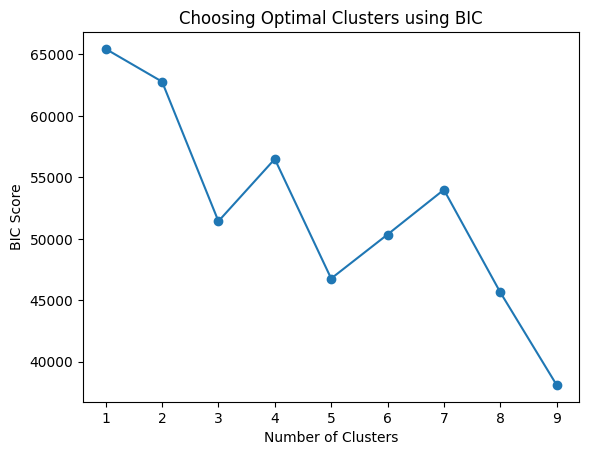

In [72]:
# use Bayesian Information Criterion to find best no. of clusters
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

bic_scores = []
for k in range(1, 10):  # try 1 to 10 clusters
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_pca_scaled)
    bic_scores.append(gmm.bic(X_pca_scaled))

plt.plot(range(1, 10), bic_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('Choosing Optimal Clusters using BIC')
plt.show()

In [78]:
# fit GMM with best cluster count (e.g., from the lowest BIC score) => 9 (min)
optimal_k = bic_scores.index(min(bic_scores)) + 1  # get best k
optimal_k = 9
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(X_pca_scaled)

ari_gmm = adjusted_rand_score(true_labels, df['GMM_Cluster'])
nmi_gmm = normalized_mutual_info_score(true_labels, df['GMM_Cluster'])

print(f'GMM - Adjusted Rand Index (ARI): {ari_gmm:.4f}')
print(f'GMM - Normalized Mutual Information (NMI): {nmi_gmm:.4f}')

GMM - Adjusted Rand Index (ARI): -0.0057
GMM - Normalized Mutual Information (NMI): 0.0020


## Agglomerative Clustering
- hierarchical clustering method that starts with each point as own cluster and merges clusters step by step
- linkage criterion:
    - ward: minimises variance, best for compact clusters
    - complete: uses max distance between clusters
    - average: uses average distance
    

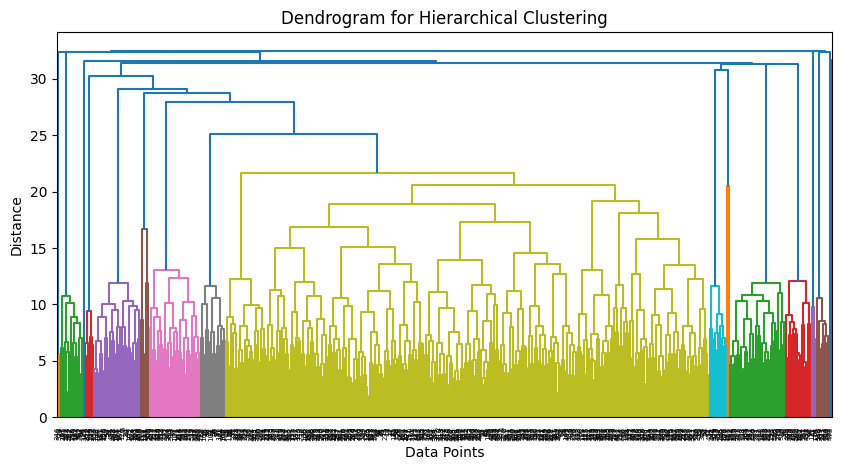

In [79]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# use dendrogram to find the best cluster count
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(X_pca_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [89]:
# adjust based on dendrogram
optimal_clusters = 6

agglo = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
df['Agglo_Cluster'] = agglo.fit_predict(X_pca_scaled)

ari_agglo = adjusted_rand_score(true_labels, df['Agglo_Cluster'])
nmi_agglo = normalized_mutual_info_score(true_labels, df['Agglo_Cluster'])

print(f'Agglomerative Clustering - Adjusted Rand Index (ARI): {ari_agglo:.4f}')
print(f'Agglomerative Clustering - Normalized Mutual Information (NMI): {nmi_agglo:.4f}')


Agglomerative Clustering - Adjusted Rand Index (ARI): 0.0088
Agglomerative Clustering - Normalized Mutual Information (NMI): 0.0130


In [90]:
print("\nComparison of Clustering Methods:")
print(f"K-Means ARI: {ari_score:.4f}, NMI: {nmi_score:.4f}")
print(f"DBSCAN ARI: {ari_dbscan:.4f}, NMI: {nmi_dbscan:.4f}")
print(f"GMM ARI: {ari_gmm:.4f}, NMI: {nmi_gmm:.4f}")
print(f"Agglomerative Clustering ARI: {ari_agglo:.4f}, NMI: {nmi_agglo:.4f}")



Comparison of Clustering Methods:
K-Means ARI: 0.2389, NMI: 0.2280
DBSCAN ARI: 0.0246, NMI: 0.0032
GMM ARI: -0.0057, NMI: 0.0020
Agglomerative Clustering ARI: 0.0088, NMI: 0.0130
